# Consensus Motif Search

This tutorial utilizes the main takeaways from the [Matrix Profile XV paper](https://www.cs.ucr.edu/~eamonn/consensus_Motif_ICDM_Long_version.pdf).

[Matrix profiles](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html) can be used to [find conserved patterns within a single time series](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) (self-join) and [across two time series](https://stumpy.readthedocs.io/en/latest/Tutorial_AB_Joins.html) (AB-join). In both cases these conserved patterns are often called "motifs". And, when considering a set of three or more time series, one common trick for identifying a conserved motif across the entire set is to: 

1. Append a `np.nan` to the end of each time series. This is used to identify the boundary between neighboring time series and ensures that any identified motif will not straddle multiple time series.
2. Concatenate all of the time series into a single long time series
3. Compute the matrix profile (self-join) on the aforementioned concatenated time series

However, this is not guaranteed to find patterns that are conserved across *all* of the time series within the set. This idea of a finding a conserved motif that is common to all of the time series in a set is referred to as a "consensus motif". In this tutorial we will introduce the "Ostinato" algorithm, which is an efficient way to find the consensus motif amongst a set of time series.

## Getting started

Let’s import the packages that we’ll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import stumpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import cycle, combinations
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.special import comb

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['xtick.direction'] = 'out'

## Loading the Eye-tracking (EOG) Dataset

In the following dataset, a volunteer was asked to "spell" out different Japanese sentences by performing eye movements that represented writing strokes of individual Japanese characters. Their eye movements were recorded by an electrooculograph (EOG) and they were given one second to "visually trace" each Japanese character. For our purposes we're only using the vertical eye positions and, conceptually, this basic example reproduced Figure 1 and Figure 2 of the [Matrix Profile XV](https://www.cs.ucr.edu/~eamonn/consensus_Motif_ICDM_Long_version.pdf) paper.

In [2]:
sentence_idx = [6, 7, 9, 10, 16, 24]
Ts = [None] * len(sentence_idx)
fs = 50  # eog signal was downsampled to 50 Hz
 
for i, s in enumerate(sentence_idx):
    Ts[i] = pd.read_csv(f'https://zenodo.org/record/4288978/files/EOG_001_01_{s:03d}.csv?download=1').iloc[:, 0].values
        
# the literal sentences
sentences = pd.read_csv(f'https://zenodo.org/record/4288978/files/test_sent.jp.csv?download=1', index_col=0)

## Visualizing the EOG Dataset

Below, we plotted six time series that each represent the vertical eye position while a person "wrote" Japanese sentences using their eyes. As you can see, some of the Japense sentences are longer and contain more words while others are shorter. However, there is one common Japanese word (i.e., a "common motif") that is contained in all six examples. Can you spot the one second long pattern that is common across these six time series?

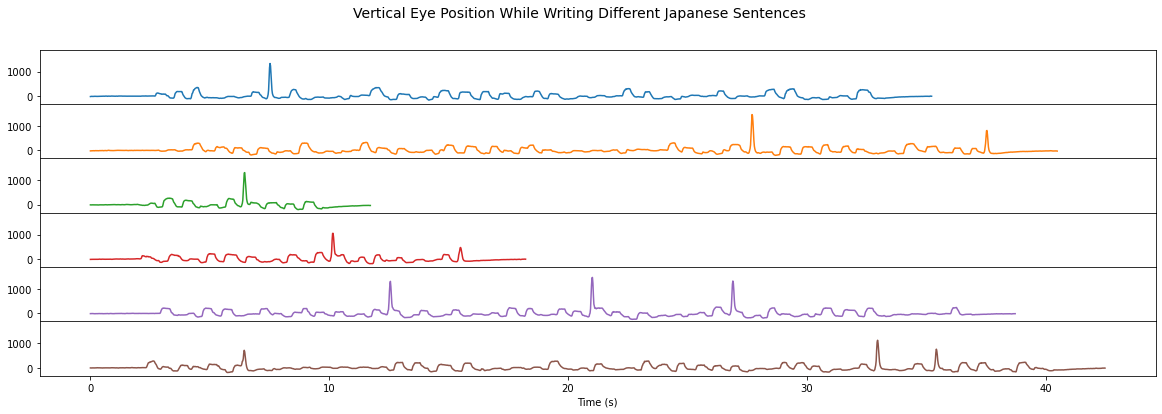

In [3]:
def plot_vertical_eog():    
    fig, ax = plt.subplots(6, sharex=True, sharey=True)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    for i, e in enumerate(Ts):
        ax[i].plot(np.arange(0, len(e)) / fs, e, color=next(colors))
        ax[i].set_ylim((-330, 1900))
    plt.subplots_adjust(hspace=0)
    plt.xlabel('Time (s)')
    return ax

plot_vertical_eog()
plt.suptitle('Vertical Eye Position While Writing Different Japanese Sentences', fontsize=14)
plt.show()

## Consensus Motif Search

To find out, we can use the `stumpy.ostinato` function to help us discover the "consensus motif" by passing in the list of time series, `Ts`, along with the subsequence window size, `m`:

In [4]:
m = fs
radius, Ts_idx, subseq_idx = stumpy.ostinato(Ts, m)
print(f'Found Best Radius {np.round(radius, 2)} in time series {Ts_idx} starting at subsequence index location {subseq_idx}.')

Found Best Radius 0.87 in time series 4 starting at subsequence index location 1271.


Now, Let's plot the individual subsequences from each time series that correspond to the matching consensus motif:

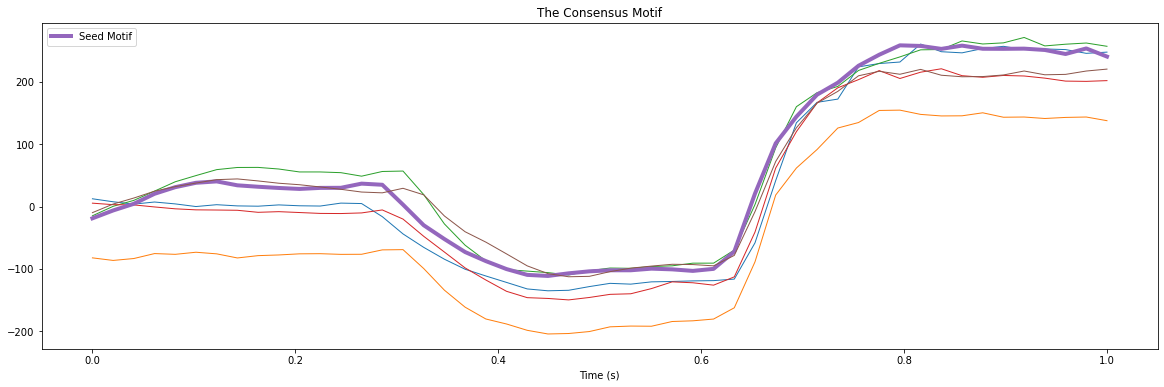

In [5]:
seed_motif = Ts[Ts_idx][subseq_idx : subseq_idx + m]
x = np.linspace(0,1,50)
nn = np.zeros(len(Ts), dtype=np.int64)
nn[Ts_idx] = subseq_idx
for i, e in enumerate(Ts):
    if i != Ts_idx:
        nn[i] = np.argmin(stumpy.core.mass(seed_motif, e))
        lw = 1
        label = None
    else:
        lw = 4
        label = 'Seed Motif'
    plt.plot(x, e[nn[i]:nn[i]+m], lw=lw, label=label)
plt.title('The Consensus Motif')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

There is a striking similarity between the subsequences. The most central "seed motif" is plotted with a thicker purple line.

When we highlight the above subsequences in their original context (light blue boxes below), we can see that they occur at different times: 

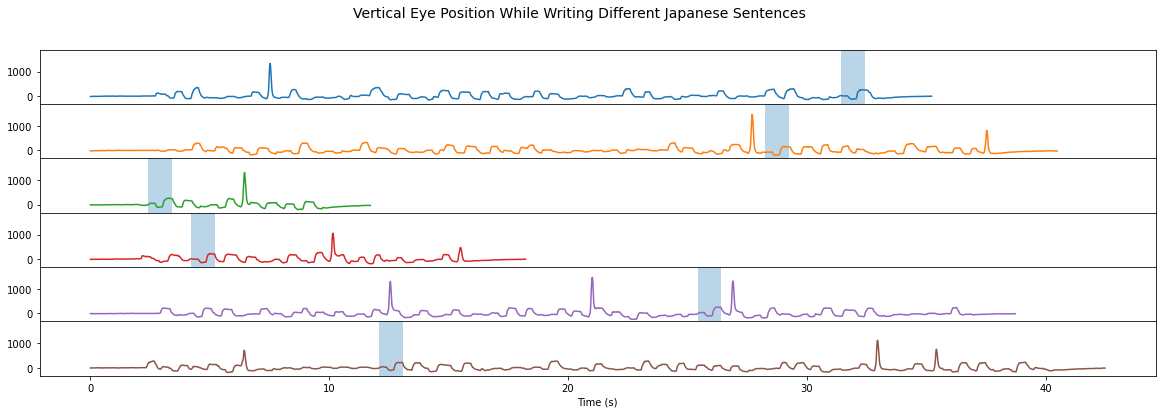

In [6]:
ax = plot_vertical_eog()
for i in range(len(Ts)):
    y = ax[i].get_ylim()
    r = Rectangle((nn[i] / fs, y[0]), 1, y[1]-y[0], alpha=0.3)
    ax[i].add_patch(r)
plt.suptitle('Vertical Eye Position While Writing Different Japanese Sentences', fontsize=14)
plt.show()

The discovered conserved motif (light blue boxes) correspond to writing the Japanese character `ア`, which occurs at different times in the different example sentences.

## Phylogeny Ssing Mitochondrial DNA (mtDNA)

In this next example, we'll reproduce Figure 9 from the [Matrix Profile XV](https://www.cs.ucr.edu/~eamonn/consensus_Motif_ICDM_Long_version.pdf) paper.

[Mitochondrial DNA (mtDNA)](https://en.wikipedia.org/wiki/Mitochondrial_DNA) has been successfully used to determine evolutionary relationships between organisms (phylogeny). Since DNAs are essentially ordered sequences of letters, we can loosely treat them as time series and use all of the available time series tools. 

## Loading the mtDNA Dataset

In [7]:
animals = ['python', 'hippo', 'red_flying_fox', 'alpaca']
data = {}
for animal in animals:
    data[animal] = pd.read_csv(f"https://zenodo.org/record/4289120/files/{animal}.csv?download=1").iloc[:,0].values
    
colors = {'python': 'tab:blue', 'hippo': 'tab:green', 'red_flying_fox': 'tab:purple', 'alpaca': 'tab:red'}

### Clustering Using Large mtDNA Sequences

Naively, using `scipy.cluster.hierarchy` we can cluster the mtDNAs based on the majority of the sequences. A correct clustering would place the two "artiodactyla", hippo and alpaca, closest and, together with the red flying fox, we would expect them to form a cluster of "mammals". Finally, the python, a "reptile", should be furthest away from all of the "mammals".

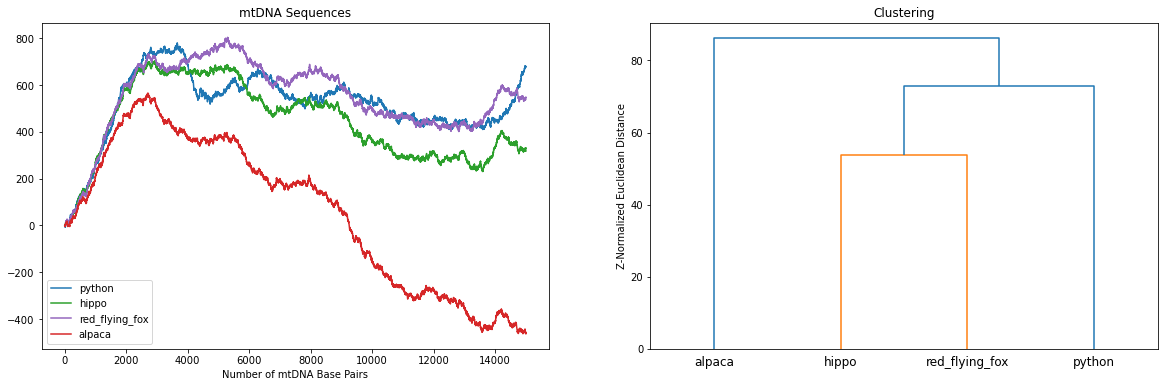

In [8]:
fig, ax = plt.subplots(ncols=2)

# sequences in Fig 9 left
truncate = 15000
for k, v in data.items():
    ax[0].plot(v[:truncate], label=k, color=colors[k])
ax[0].legend()
ax[0].set_xlabel('Number of mtDNA Base Pairs')
ax[0].set_title('mtDNA Sequences')

# clustering in Fig 9 left
truncate = 16000
dp = np.zeros(int(comb(4, 2)))
for i, a_c in enumerate(combinations(data.keys(), 2)):
    dp[i] = stumpy.core.mass(data[a_c[0]][:truncate], data[a_c[1]][:truncate])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in data.keys()], ax=ax[1])
ax[1].set_ylabel('Z-Normalized Euclidean Distance')
ax[1].set_title('Clustering')
plt.show()

Uh oh, the clustering is clearly wrong! Amongst other problems, the alpaca (a mammal) should not be most closely related to the python (a reptile).

## Consensus Motif Search

In order to obtain the correct relationships, we need to identify and then compare the parts of the mtDNA that is the most conserved across the mtDNA sequences. In other words, we need to cluster based on their consensus motif. Let's limit the subsequence window size to 1,000 base pairs and identify the consensus motif again using the `stumpy.ostinato` function:

In [9]:
m = 1000
bsf_radius, bsf_Ts_idx, bsf_subseq_idx = stumpy.ostinato(list(data.values()), m)
print(f'Found best radius {np.round(bsf_radius, 2)} in time series {bsf_Ts_idx} starting at subsequence index location {bsf_subseq_idx}.')

Found best radius 2.73 in time series 1 starting at subsequence index location 602.


## Clustering Using the Consensus mtDNA Motif

Now, let's perform the clustering again but, this time, using the consensus motif:

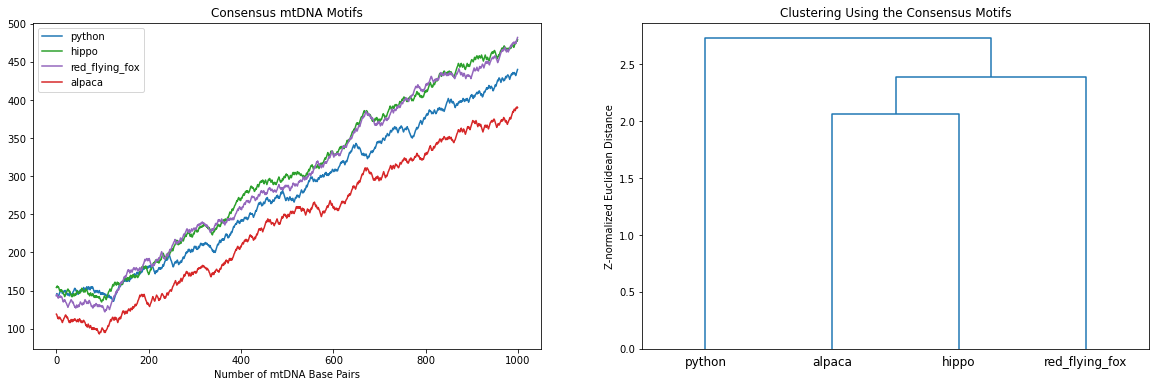

In [10]:
consensus_motifs = {}
best_motif = list(data.items())[bsf_Ts_idx][1][bsf_subseq_idx : bsf_subseq_idx + m]
for i, (k, v) in enumerate(data.items()):
    if i == bsf_Ts_idx:
        consensus_motifs[k] = best_motif
    else:
        idx = np.argmin(stumpy.core.mass(best_motif, v))
        consensus_motifs[k] = v[idx : idx + m]
        
fig, ax = plt.subplots(ncols=2)
# plot the consensus motifs
for animal, motif in consensus_motifs.items():
    ax[0].plot(motif, label=animal, color=colors[animal])
ax[0].legend()
# cluster consensus motifs
dp = np.zeros(int(comb(4, 2)))
for i, motif in enumerate(combinations(list(consensus_motifs.values()), 2)):
    dp[i] = stumpy.core.mass(motif[0], motif[1])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in consensus_motifs.keys()])

ax[0].set_title('Consensus mtDNA Motifs')
ax[0].set_xlabel('Number of mtDNA Base Pairs')
ax[1].set_title('Clustering Using the Consensus Motifs')
ax[1].set_ylabel('Z-normalized Euclidean Distance')
plt.show()

Now this looks much better! Hierarchically, the python is "far away" from the other mammals and, amongst the mammalia, the red flying fox (a bat) is less related to both the alpaca and the hippo which are the closest evolutionary relatives in this set of animals.

## Summary

And that’s it! You have now learned how to search for a consensus motif amongst a set of times series using the awesome `stumpy.ostinato` function. You can now import this package and use it in your own projects. Happy coding!

## Resources

[Matrix Profile XV](https://www.cs.ucr.edu/~eamonn/consensus_Motif_ICDM_Long_version.pdf)